In [1]:
import numpy as np
from numpy import genfromtxt
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# general work flow
# read in CSV file
mcsol = genfromtxt('mcsol.csv',delimiter=',')
print(mcsol.shape)

(401,)


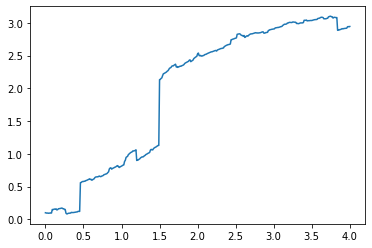

In [3]:
# constant diffusion
g = 0.25

# levy alpha parameter
alpha = 1.0

# time step
h = 0.01

# time vector
tvec = np.arange(mcsol.shape[0])*h

plt.plot(tvec, mcsol)
plt.show()

In [4]:
# for stretch = 1, this is an equispaced grid on the closed interval [-lmax, lmax]
# for stretch > 1, this is a way to create a non-equispaced grid on [-lmax, lmax]
#                  that is highly concentrated near the origin
npts = 1601
stretch = 1.0
lmax = 800

du = 2.0/(npts - 1)
startvec = -1.0 + np.arange(npts)*du
uvec = lmax*np.sign(startvec)*(np.abs(startvec)**stretch)

# this is a scaling factor used in all the collocation functions below
zeta = 1.0

In [5]:
# CHARACTERISTIC FUNCTION OF THE CAUCHY PDF,
# looks like an UNNORMALIZED LAPLACE PDF, 
# beautiful but sadly non-differentiable at the origin
# def xi(u):
#     return np.exp(-np.abs(u/zeta))

# CHARBONNIER FUNCTIONS, smoothed versions of the above unnormalized Laplace PDF
def xi(u):
    return np.exp(-(np.sqrt((u/zeta)**2 + 0.01) - 0.1))
# def dxi(u):
#     return -((u/zeta**2)/np.sqrt(0.01+(u/zeta)**2))*xi(u)
# def ddxi(u):
#     grabxi = xi(u)
#     numter = u**2/zeta**4
#     denter = (0.01 + (u/zeta)**2)
#     part1 = numter*grabxi/denter**(1.5)
#     part2 = numter*grabxi/denter
#     part3 = grabxi/(zeta**2*np.sqrt(denter))
#     return part1+part2-part3

# HOMEGROWN SMOOTHING OF unnormalized LAPLACE PDF
# def xi(u):
#     return (np.abs(u) <= 0.1)*np.exp(-u**2/(0.1)) + (np.abs(u) > 0.1)*np.exp(-np.abs(u))

# HOMEGROWN POLYNOMIALS, ZERO OUTSIDE THE INTERVAL [-zeta, zeta],
# WITH FIRST TWO DERIVATIVES = 0 AT THE ENDPOINTS
# def xi(u):
#     return (np.abs(u) <= zeta) * (1.0 - np.abs(u)/zeta) # (1.0-(u/zeta)**2)**3
# def dxi(u):
#     return (np.abs(u) <= zeta) * (-6.0*(u/zeta**2) * (1.0-(u/zeta)**2)**2)
# def ddxi(u):
#     part1 = 24*(u**2/zeta**4) * (1.0-(u/zeta)**2)
#     part2 = -(6/zeta**2) * (1.0-(u/zeta)**2)**2
#     return (np.abs(u) <= zeta) * (part1 + part2)

C:\Users\haris\Miniconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


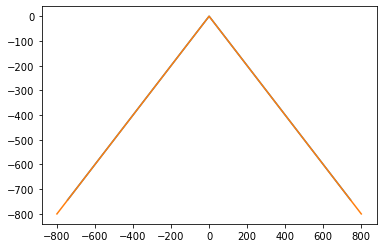

In [6]:
# comparing, on a log scale, our chosen collocation function versus the unnormalized Laplace
plt.plot(uvec, np.log(xi(uvec)))
plt.plot(uvec, -np.abs(uvec/zeta))

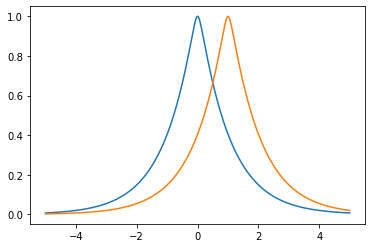

In [7]:
# checking to see how much overlap we have on our grid in u space
uuvec = np.linspace(-5,5,401)
plt.plot(uuvec, xi(uuvec-uvec[(npts-1)//2 + 0]))
plt.plot(uuvec, xi(uuvec-uvec[(npts-1)//2 + 1]))

In [8]:
# all the matrices are defined in the notes
udiffmat = (np.expand_dims(uvec,0) - np.expand_dims(uvec,0).T)
a = xi(udiffmat)
am1 = xi(udiffmat - 1)
ap1 = xi(udiffmat + 1)
am2 = xi(udiffmat - 2)
ap2 = xi(udiffmat + 2)
b = 0.5*h*(ap1 - am1) @ np.diag(uvec) + 0.125*h**2*(am2 - 2*a + ap2) @ np.diag(uvec**2)
d = np.diag(np.exp(-h*np.abs(uvec*g)**alpha))

In [9]:
# operator splitting
propagator = np.linalg.inv(a - d @ b.T) @ d @ a

# no splitting -- warning, probably unstable
# propagator = np.linalg.inv(a) @ d @ (a + b)


In [10]:
# check stability of propagator
np.max(np.abs(np.linalg.eig(propagator)[0]))

0.9999999999999972

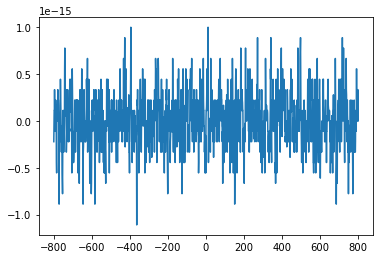

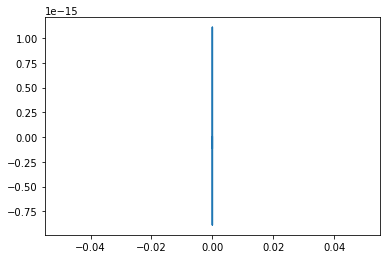

In [11]:
# set up initial condition, a mean-zero Gaussian (characteristic function)
initvar = 0.05
#psi0 = np.exp(-(initvar**2/2)*uvec**2)
# psi0 = np.ones(uvec.shape)
psi0 = np.exp(1j*0.5*uvec)

# represent initial condition using collocation functions
gamma = np.linalg.inv(a) @ psi0

# check to see how well we can reconstruct the initial condition 
plt.plot(np.real(uvec), np.real(a @ gamma - psi0))
plt.show()
plt.plot(np.imag(uvec), np.imag(a @ gamma - psi0))
plt.show()



In [12]:
# def evaluator(g, s):
#     return np.dot( xi(s - uvec) , g )
# pt = 150.0
# print( evaluator(gammamat[:, 0], pt) )
# print( np.exp(-(initvar**2/2)*(pt)**2) )
print(uvec[(npts-1)//2])

0.0


In [64]:
# set up time stepping
# store all the characteristic functions
numsteps = 401
regsig = 0.005
gammax0 = np.exp(1j*np.outer(uvec,mcsol[0:(numsteps-1)]))
gammax0 = np.expand_dims(np.exp(-(regsig**2)*(uvec**2)/2),1) * gammax0
gammax1 = propagator @ gammax0

# gammamat = np.zeros((npts, numsteps))
# gammamat[:, 0] = gamma

# for iii in range(numsteps):
#     gammamat[:, iii+1] = propagator @ gammamat[:, iii]
#     normalization = a[(npts-1)//2, :] @ gammamat[:, iii+1]
#     print(normalization)
    
#     # forcefully renormalized at every time step
#     # we'd like to avoid doing this, as this is a total hack:
#     # gammamat[:, iii+1] /= normalization
#     # print( a[(npts-1)//2, :] @ gammamat[:, iii+1] )


(2000,)


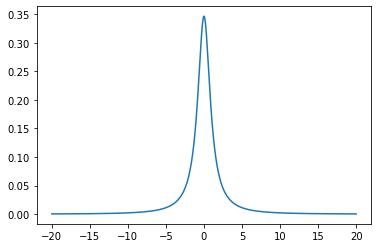

In [65]:
xmax = 20
xpts = 2000
xvec = np.linspace(-xmax, xmax, xpts)
ftmat = np.exp(-1j * np.expand_dims(uvec,1) @ np.expand_dims(xvec, 0))

base = np.loadtxt('charboninv.csv')
print(base.shape)
plt.plot(xvec,base)

from scipy import interpolate
charboninv = interpolate.interp1d(xvec, base)

In [66]:
loglik = np.zeros(numsteps-1)
for j in range(numsteps-1):
    thispdf = interpolate.interp1d(xvec, np.real( gammax1[:,j] @ ftmat ))
    loglik[j] = np.log( thispdf(mcsol[j+1]) * charboninv(mcsol[j+1]) )

print(np.sum(loglik))

908.4240232012171


In [67]:
np.min(loglik)

-7.293240192963802

In [22]:
xmax = 20
xpts = 2000
xvec = np.linspace(-xmax, xmax, xpts)
ftmat = np.exp(-1j * np.expand_dims(uvec,1) @ np.expand_dims(xvec, 0))

# going backwards from the characteristic function to the Cauchy PDF,
# with scaling factor zeta included:
# base = zeta/(np.pi*(1.0 + zeta**2*xvec**2))

# going backwards for Charbonnier -- no closed-form inverse Fourier transform
# had to do this numerically in Mathematica
base = np.loadtxt('charboninv.csv')

# going backwards for my homegrown smoothing of the Laplace
# had to do this numerically in Mathematica
# base = np.loadtxt('myfuncinv.csv')

# going backwards from our C^2 homegrown polynomials, again
# with scaling factor zeta included
# base = (1.0-np.cos(xvec*zeta))/(np.pi*xvec**2*zeta)

# reconstruct PDF from final characteristic function
mypdf = np.real(gammamat[:, numsteps] @ ftmat) * base

NameError: name 'gammamat' is not defined

In [21]:
base.shape

NameError: name 'base' is not defined

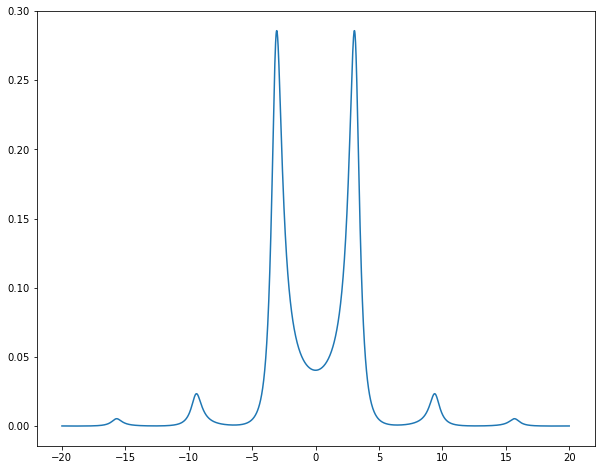

In [23]:
plt.figure(figsize=(10,8))
plt.plot(xvec, mypdf)
plt.savefig('deltapdf.png')

In [16]:
# b = a - h*dxi(udiffmat) @ np.diag(uvec) + 0.5 * h**2 * ddxi(udiffmat) @ np.diag(uvec**2)


In [24]:
np.trapz(mypdf,xvec)

0.9931540400442725